<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/pybaseball_random_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pybaseball

     |████████████████████████████████| 419kB 8.8MB/s 
     |████████████████████████████████| 81kB 7.7MB/s 
     |████████████████████████████████| 296kB 20.7MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [ ]:
import pickle
import os
import warnings
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pybaseball

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error
from sklearn.model_selection import GroupKFold, KFold
from scipy.stats import pearsonr

dt_str = format(datetime.datetime.now(), '%Y%M%d%H%M%S')

In [ ]:
project_dir = 'drive/My Drive/baseball'

In [ ]:
df = pd.read_csv(f"{project_dir}/data/2018_2020_data.csv")
df.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (45) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1754439, 91)

In [ ]:
in_play = [x for x in df['description'].unique() if 'hit_into_play' in x]
bip = df.loc[df['description'].isin(in_play)]
for event in bip['events'].unique():
  bip[f'is_{event}'] = 0
  bip.loc[bip['events']==event, f'is_{event}'] = 1
bip['park'] = bip['home_team'].astype('category').cat.codes
park_lkup = bip.loc[:, ['home_team','park']].drop_duplicates()
park_lkup.to_csv(f"{project_dir}/data/park_lkup.csv", index=False)
for col in ['if_fielding_alignment', 'of_fielding_alignment']:
  bip[f'{col}_code'] = bip[col].astype('category').cat.codes
bip = bip.merge(bip.loc[:, ['on_3b', 'on_2b', 'on_1b']].fillna(0).astype(bool).astype(int).rename(columns={'on_3b':'is_on_3b', 'on_2b':'is_on_2b', 'on_1b':'is_on_1b'}), left_index=True, right_index=True)
bip['is_top'] = 0
bip.loc[bip['inning_topbot']=='Top', 'is_top'] = 1
bip['bat_left'] = 0
bip.loc[bip['stand']=='L', 'bat_left'] = 1
bip['pit_left'] = 0
bip.loc[bip['p_throws']=='L', 'pit_left'] = 1
bip.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

(302023, 117)

In [ ]:
park_lkup = pd.read_csv(f"{project_dir}/data/park_lkup.csv")
not_in_play = [x for x in df['description'].unique() if 'hit_into_play' not in x]
nbip = df.loc[df['description'].isin(not_in_play)]
for event in nbip['events'].unique():
  nbip[f'is_{event}'] = 0
  nbip.loc[nbip['events']==event, f'is_{event}'] = 1
nbip = nbip.merge(park_lkup)
for col in ['if_fielding_alignment', 'of_fielding_alignment']:
  nbip[f'{col}_code'] = nbip[col].astype('category').cat.codes
nbip = nbip.drop('is_nan', axis=1)
nbip = nbip.merge(nbip.loc[:, ['on_3b', 'on_2b', 'on_1b']].fillna(0).astype(bool).astype(int).rename(columns={'on_3b':'is_on_3b', 'on_2b':'is_on_2b', 'on_1b':'is_on_1b'}), left_index=True, right_index=True)
nbip['is_top'] = 0
nbip.loc[nbip['inning_topbot']=='Top', 'is_top'] = 1
nbip['bat_left'] = 0
nbip.loc[nbip['stand']=='L', 'bat_left'] = 1
nbip['pit_left'] = 0
nbip.loc[nbip['p_throws']=='L', 'pit_left'] = 1
nbip.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


(1452416, 117)

In [ ]:
feats = ['game_year','park', 'inning', 'is_top', 'outs_when_up', 'balls',
         'strikes', 'is_on_3b', 'is_on_2b', 'is_on_1b', 'release_spin_rate',
         'pfx_x', 'pfx_z','plate_x', 'plate_z', 'effective_speed',
         'if_fielding_alignment_code', 'of_fielding_alignment_code',
         'bat_left', 'pit_left']
nbip_models = {}
targets = [x for x in nbip.columns.values if ('is_' in x) & (x not in ['is_on_3b','is_on_2b','is_on_1b','is_top']) & ('pickoff' not in x) & ('caught' not in x) & ('run' not in x)]
for target in targets:
  model_data = nbip.loc[:, feats+[target]].dropna()
  model = RandomForestClassifier()
  model.fit(model_data.loc[:, feats], model_data.loc[:, target])
  nbip_models[target] = model

with open(f'{project_dir}/models/{dt_str}_nbip_batter_models.pickle', 'wb') as handle:
    pickle.dump(nbip_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
feats = ['game_year','park', 'inning', 'is_top', 'outs_when_up', 'balls',
         'strikes', 'is_on_3b', 'is_on_2b', 'is_on_1b', 'release_spin_rate',
         'pfx_x', 'pfx_z','plate_x', 'plate_z', 'effective_speed',
         'if_fielding_alignment_code', 'of_fielding_alignment_code',
         'bat_left', 'pit_left', 'launch_speed', 'launch_angle']
bip_models = {}
targets = [x for x in bip.columns.values if ('is_' in x) & (x not in ['is_on_3b','is_on_2b','is_on_1b','is_top'])]
for target in targets:
  model_data = bip.loc[:, feats+[target]].dropna()
  model = RandomForestClassifier()
  model.fit(model_data.loc[:, feats], model_data.loc[:, target])
  bip_models[target] = model

with open(f'{project_dir}/models/{dt_str}_bip_batter_models.pickle', 'wb') as handle:
    pickle.dump(bip_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
warnings.filterwarnings('ignore')
targets = [x for x in nbip.columns.values if ('is_' in x) & (x not in ['is_on_3b','is_on_2b','is_on_1b','is_top']) & ('pickoff' not in x) & ('caught' not in x) & ('run' not in x)]
feats = ['game_year','park', 'inning', 'is_top', 'outs_when_up', 'balls',
         'strikes', 'is_on_3b', 'is_on_2b', 'is_on_1b', 'release_spin_rate',
         'pfx_x', 'pfx_z','plate_x', 'plate_z', 'effective_speed',
         'if_fielding_alignment_code', 'of_fielding_alignment_code',
         'bat_left', 'pit_left']
kf = GroupKFold(5)
model_data = nbip.loc[:, feats+targets+['batter', 'game_pk']].dropna()

for target_idx, target in enumerate(targets):
  print(f"modeling {target}...")
  _df_pred = pd.DataFrame()
  for train_idx, test_idx in kf.split(model_data, groups=model_data['batter']):
    train_data = model_data.iloc[train_idx]
    test_data = model_data.iloc[test_idx]
    model = RandomForestClassifier()
    model.fit(train_data.loc[:, feats], train_data.loc[:, target])
    try:
      test_data[f"{target}_rf"] = pd.DataFrame(model.predict_proba(test_data.loc[:, feats]), index=test_data.index)[1]
    except:
      test_data[f"{target}_rf"] = pd.DataFrame(model.predict_proba(test_data.loc[:, feats]), index=test_data.index)[0]
      test_data[f"{target}_rf"] = 1-test_data[f"{target}_rf"]
    _df_pred = _df_pred.append(test_data)
  if target_idx==0:
    df_pred_nbip = _df_pred.copy()
  else:
    df_pred_nbip = df_pred_nbip.merge(_df_pred.loc[:, ['batter',f"{target}_rf"]+feats])
warnings.filterwarnings('default')
df_pred_nbip.to_csv(f'{project_dir}/data/df_pred_nbip.csv', index=False)

modeling is_strikeout...
modeling is_walk...
modeling is_hit_by_pitch...
modeling is_interf_def...
modeling is_other_out...
modeling is_strikeout_double_play...
modeling is_batter_interference...


In [ ]:
warnings.filterwarnings('ignore')
targets = [x for x in bip.columns.values if ('is_' in x) & (x not in ['is_on_3b','is_on_2b','is_on_1b','is_top'])]
feats = ['game_year','park', 'inning', 'is_top', 'outs_when_up', 'balls',
         'strikes', 'is_on_3b', 'is_on_2b', 'is_on_1b', 'release_spin_rate',
         'pfx_x', 'pfx_z','plate_x', 'plate_z', 'effective_speed',
         'if_fielding_alignment_code', 'of_fielding_alignment_code',
         'bat_left', 'pit_left', 'launch_speed', 'launch_angle']
kf = GroupKFold(5)
model_data = bip.loc[:, feats+targets+['batter', 'game_pk']].dropna()

for target_idx, target in enumerate(targets):
  print(f"modeling {target}...")
  _df_pred = pd.DataFrame()
  for train_idx, test_idx in kf.split(model_data, groups=model_data['batter']):
    train_data = model_data.iloc[train_idx]
    test_data = model_data.iloc[test_idx]
    model = RandomForestClassifier()
    model.fit(train_data.loc[:, feats], train_data.loc[:, target])
    try:
      test_data[f"{target}_rf"] = pd.DataFrame(model.predict_proba(test_data.loc[:, feats]), index=test_data.index)[1]
    except:
      test_data[f"{target}_rf"] = pd.DataFrame(model.predict_proba(test_data.loc[:, feats]), index=test_data.index)[0]
      test_data[f"{target}_rf"] = 1-test_data[f"{target}_rf"]
    _df_pred = _df_pred.append(test_data)
  if target_idx==0:
    df_pred_bip = _df_pred.copy()
  else:
    df_pred_bip = df_pred_bip.merge(_df_pred.loc[:, ['batter',f"{target}_rf"]+feats])
warnings.filterwarnings('default')
df_pred_bip.to_csv(f'{project_dir}/data/df_pred_bip.csv', index=False)

modeling is_field_out...
modeling is_double...
modeling is_home_run...
modeling is_single...
modeling is_double_play...
modeling is_force_out...
modeling is_triple...
modeling is_grounded_into_double_play...
modeling is_sac_bunt...
modeling is_sac_fly...
modeling is_fielders_choice_out...
modeling is_field_error...
modeling is_fielders_choice...
modeling is_triple_play...
modeling is_sac_fly_double_play...
modeling is_sac_bunt_double_play...
modeling is_interf_def...


In [ ]:
df_pred_nbip = pd.read_csv(f'{project_dir}/data/df_pred_nbip.csv')
df_pred_bip = pd.read_csv(f'{project_dir}/data/df_pred_bip.csv')
targets = [x for x in nbip.columns.values if ('is_' in x) & (x not in ['is_on_3b','is_on_2b','is_on_1b','is_top']) & ('pickoff' not in x) & ('caught' not in x) & ('run' not in x)]
_bats = df_pred_nbip.loc[:, ['game_year', 'batter']+[targets[0]]].groupby(['game_year', 'batter'], as_index=False).count().rename(columns={targets[0]:'n_nbip'})
bats_nbip = df_pred_nbip.loc[:, ['game_year', 'batter']+targets+[f"{x}_rf" for x in targets]].groupby(['game_year', 'batter'], as_index=False).sum().merge(_bats)
for target in targets:
  bats_nbip[f'{target}_rate'] = bats_nbip[f'{target}'].div(bats_nbip['n_nbip'])
  bats_nbip[f'{target}_xrate'] = bats_nbip[f'{target}_rf'].div(bats_nbip['n_nbip'])

targets = [x for x in bip.columns.values if ('is_' in x) & (x not in ['is_on_3b','is_on_2b','is_on_1b','is_top'])]
_bats = df_pred_bip.loc[:, ['game_year', 'batter']+[targets[0]]].groupby(['game_year', 'batter'], as_index=False).count().rename(columns={targets[0]:'n_bip'})
bats = df_pred_bip.loc[:, ['game_year', 'batter']+targets+[f"{x}_rf" for x in targets]].groupby(['game_year', 'batter'], as_index=False).sum().merge(_bats)
for target in targets:
  bats[f'{target}_rate'] = bats[f'{target}'].div(bats['n_bip'])
  bats[f'{target}_xrate'] = bats[f'{target}_rf'].div(bats['n_bip'])

nbip_rename = {x:f"{x}_nbip" for x in bats.columns.values if (x in bats_nbip.columns.values) and (x not in ['batter', 'game_year'])}
bats = bats.merge(bats_nbip.rename(columns=nbip_rename))
bats.shape

(2352, 100)

In [ ]:
bat_ids = pybaseball.playerid_reverse_lookup(bats['batter'].unique())
bat_ids['full_name'] = bat_ids['name_last'].add(', ').add(bat_ids['name_first'])
fg = pybaseball.fg_batting_data(2018, 2020, qual=1)
fg_war = fg.loc[:, ['Season','IDfg', 'WAR']].groupby(['Season','IDfg'], as_index=False).sum()
_bats = bat_ids.loc[:, ['full_name', 'key_mlbam', 'key_fangraphs']].rename(columns={'key_mlbam':'batter', 'key_fangraphs':'IDfg'}).merge(fg_war).rename(columns={'Season':'game_year'})
bats = bats.merge(_bats)

war_feats = [x for x in bats.columns.values if 'xrate' in x]
feats = ['game_year'] + war_feats
target = 'WAR'
model_data = bats.loc[:, feats+[target]].dropna()
war_model = RandomForestRegressor()
war_model.fit(model_data.loc[:, feats], model_data.loc[:, target])

with open(f'{project_dir}/models/{dt_str}_war_batter_model.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
warnings.filterwarnings('ignore')
bat_ids = pybaseball.playerid_reverse_lookup(bats['batter'].unique())
bat_ids['full_name'] = bat_ids['name_last'].add(', ').add(bat_ids['name_first'])
fg = pybaseball.fg_batting_data(2018, 2020, qual=1)
fg_war = fg.loc[:, ['Season','IDfg', 'WAR']].groupby(['Season','IDfg'], as_index=False).sum()
_bats = bat_ids.loc[:, ['full_name', 'key_mlbam', 'key_fangraphs']].rename(columns={'key_mlbam':'batter', 'key_fangraphs':'IDfg'}).merge(fg_war).rename(columns={'Season':'game_year'})
bats = bats.merge(_bats)

war_feats = [x for x in bats.columns.values if 'xrate' in x]
feats = ['game_year'] + war_feats
target = 'WAR'
kf = GroupKFold(10)
df_pred = pd.DataFrame()
for train_idx, test_idx in kf.split(bats, groups=bats['IDfg']):
  train_data = bats.iloc[train_idx]
  test_data = bats.iloc[test_idx]
  model = LinearRegression()
  model.fit(train_data.loc[:, feats], train_data.loc[:, target])
  test_data[f"x{target}"] = pd.Series(model.predict(test_data.loc[:, feats]), index=test_data.index)

  model = RandomForestRegressor()
  model.fit(train_data.loc[:, feats], train_data.loc[:, target])
  test_data[f"x{target}_rf"] = pd.Series(model.predict(test_data.loc[:, feats]), index=test_data.index)
  df_pred = df_pred.append(test_data)
df_pred[f"{target}_diff"] = df_pred[target].sub(df_pred[f"x{target}_rf"])
warnings.filterwarnings('default')
df_pred.to_csv(f'{project_dir}/data/war_preds.csv', index=False)
df_pred.shape


Gathering player lookup table. This may take a moment.


(2275, 106)

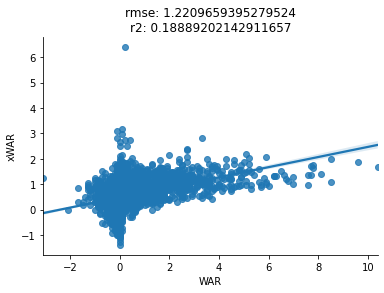

In [ ]:
target = 'WAR'
r2 = pearsonr(df_pred[target], df_pred[f"x{target}"])[0]**2
rmse = mean_squared_error(df_pred[target], df_pred[f"x{target}"])**0.5
sns.regplot(data=df_pred,x=target,y=f'x{target}')
plt.title(f"""rmse: {rmse}\nr2: {r2}""")
sns.despine()
plt.show()

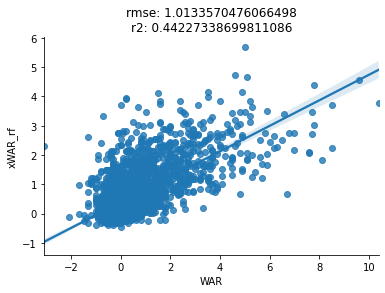

In [ ]:
target = 'WAR'
r2 = pearsonr(df_pred[target], df_pred[f"x{target}_rf"])[0]**2
rmse = mean_squared_error(df_pred[target], df_pred[f"x{target}_rf"])**0.5
sns.regplot(data=df_pred,x=target,y=f'x{target}_rf')
plt.title(f"""rmse: {rmse}\nr2: {r2}""")
sns.despine()
plt.show()

In [ ]:
df_pred.sort_values(f"x{target}_rf",ascending=False).loc[:, ['game_year', 'full_name', target, f"x{target}_rf", f"{target}_diff"]].head(20)

,game_year,full_name,WAR,xWAR_rf,WAR_diff
424,2018.0,"carpenter, matt",5.0,5.675,-0.675
1173,2019.0,"harper, bryce",4.6,4.716,-0.116
462,2018.0,"judge, aaron",5.1,4.677,0.423
337,2018.0,"trout, mike",9.6,4.541,5.059
1569,2019.0,"bellinger, cody",7.8,4.375,3.425
113,2018.0,"votto, joey",3.5,4.145,-0.645
1741,2019.0,"soto, juan",4.9,4.140,0.760
969,2019.0,"mccutchen, andrew",1.5,4.122,-2.622
345,2018.0,"harper, bryce",3.5,3.972,-0.472
35,2018.0,"morales, kendrys",0.2,3.936,-3.736


In [ ]:
df_pred.sort_values(f"x{target}_rf",ascending=False).loc[:, ['game_year', 'full_name', target, f"x{target}_rf", f"{target}_diff"]].tail(20)

,game_year,full_name,WAR,xWAR_rf,WAR_diff
1436,2019.0,"williamson, mac",-0.6,-0.272,-0.328
1460,2019.0,"stamets, eric",-0.7,-0.276,-0.424
1546,2019.0,"nunez, dom",-0.1,-0.278,0.178
181,2018.0,"quintana, jose",-0.3,-0.294,-0.006
1278,2019.0,"ray, robbie",-0.4,-0.295,-0.105
1052,2019.0,"sanchez, adrian",-0.2,-0.300,0.100
850,2018.0,"newcomb, sean",-0.3,-0.305,0.005
1423,2019.0,"reed, a. j.",-0.6,-0.306,-0.294
1988,2020.0,"ravelo, rangel",-0.1,-0.311,0.211
1075,2019.0,"kelly, merrill",-0.5,-0.312,-0.188


In [ ]:
df_pred.sort_values('WAR_diff',ascending=False).loc[:, ['game_year', 'full_name', target, f"x{target}_rf", f"{target}_diff"]].head(20)

,game_year,full_name,WAR,xWAR_rf,WAR_diff
572,2018.0,"betts, mookie",10.4,3.789,6.611
645,2018.0,"ramirez, jose",8.1,1.834,6.266
1438,2019.0,"bregman, alex",8.5,2.244,6.256
843,2018.0,"chapman, matt",6.7,0.654,6.046
646,2018.0,"bregman, alex",7.6,2.065,5.535
1149,2019.0,"semien, marcus",7.6,2.090,5.510
337,2018.0,"trout, mike",9.6,4.541,5.059
535,2018.0,"lindor, francisco",7.7,2.709,4.991
1413,2019.0,"marte, ketel",7.0,2.157,4.843
1165,2019.0,"trout, mike",8.5,3.700,4.800


In [ ]:
df_pred.sort_values('WAR_diff',ascending=False).loc[:, ['game_year', 'full_name', target, f"x{target}_rf", f"{target}_diff"]].tail(20)

,game_year,full_name,WAR,xWAR_rf,WAR_diff
52,2018.0,"duda, lucas",0.0,2.536,-2.536
452,2018.0,"drury, brandon",-0.5,2.048,-2.548
969,2019.0,"mccutchen, andrew",1.5,4.122,-2.622
375,2018.0,"bour, justin",0.5,3.128,-2.628
1607,2019.0,"vanmeter, josh",0.2,2.830,-2.630
1004,2019.0,"zimmerman, ryan",0.1,2.756,-2.656
3,2018.0,"martinez, victor",-1.7,0.988,-2.688
1604,2019.0,"tellez, rowdy",0.1,2.802,-2.702
458,2018.0,"healy, ryon",-0.9,1.859,-2.759
1194,2019.0,"adams, matt",-0.1,2.753,-2.853


In [ ]:
# save for validation stats
# model_type = 'rf'
# acc = accuracy_score(df_pred[target], round(df_pred[f"{target}_{model_type}"], 0))
# loss = log_loss(df_pred[target], df_pred[f"{target}_{model_type}"])
# sns.boxplot(data=df_pred, x=target, y=f"{target}_{model_type}")
# plt.title(f"acc: {acc}\nloss: {loss}")
# sns.despine()
# plt.show()

'2021-04-18'

In [ ]:
df_cur = pybaseball.statcast(start_dt='2021-03-20', end_dt=format(datetime.datetime.now(), "%Y-%m-%d"))
df_cur.shape

This is a large query, it may take a moment to complete


100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


(88003, 92)

In [ ]:
park_lkup = pd.read_csv(f"{project_dir}/data/park_lkup.csv")

in_play = [x for x in df_cur['description'].unique() if 'hit_into_play' in x]
bip = df_cur.loc[df['description'].isin(in_play)]
for event in bip['events'].unique():
  bip[f'is_{event}'] = 0
  bip.loc[bip['events']==event, f'is_{event}'] = 1
bip = bip.merge(park_lkup)
for col in ['if_fielding_alignment', 'of_fielding_alignment']:
  bip[f'{col}_code'] = bip[col].astype('category').cat.codes
bip = bip.merge(bip.loc[:, ['on_3b', 'on_2b', 'on_1b']].fillna(0).astype(bool).astype(int).rename(columns={'on_3b':'is_on_3b', 'on_2b':'is_on_2b', 'on_1b':'is_on_1b'}), left_index=True, right_index=True)
bip['is_top'] = 0
bip.loc[bip['inning_topbot']=='Top', 'is_top'] = 1
bip['bat_left'] = 0
bip.loc[bip['stand']=='L', 'bat_left'] = 1
bip['pit_left'] = 0
bip.loc[bip['p_throws']=='L', 'pit_left'] = 1
print(bip.shape)


not_in_play = [x for x in df_cur['description'].unique() if 'hit_into_play' not in x]
nbip = df_cur.loc[df_cur['description'].isin(not_in_play)]
for event in nbip['events'].unique():
  nbip[f'is_{event}'] = 0
  nbip.loc[nbip['events']==event, f'is_{event}'] = 1
nbip = nbip.merge(park_lkup)
for col in ['if_fielding_alignment', 'of_fielding_alignment']:
  nbip[f'{col}_code'] = nbip[col].astype('category').cat.codes
nbip = nbip.drop('is_nan', axis=1)
nbip = nbip.merge(nbip.loc[:, ['on_3b', 'on_2b', 'on_1b']].fillna(0).astype(bool).astype(int).rename(columns={'on_3b':'is_on_3b', 'on_2b':'is_on_2b', 'on_1b':'is_on_1b'}), left_index=True, right_index=True)
nbip['is_top'] = 0
nbip.loc[nbip['inning_topbot']=='Top', 'is_top'] = 1
nbip['bat_left'] = 0
nbip.loc[nbip['stand']=='L', 'bat_left'] = 1
nbip['pit_left'] = 0
nbip.loc[nbip['p_throws']=='L', 'pit_left'] = 1
print(nbip.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


(9775, 123)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(71284, 114)


In [ ]:
warnings.filterwarnings('ignore')
targets = list(nbip_models.keys())
nan_cols = [a for a in targets if a not in [x for x in nbip.columns.values if x in targets] ]
for col in nan_cols:
  nbip[col] = 0
feats = ['game_year','park', 'inning', 'is_top', 'outs_when_up', 'balls',
         'strikes', 'is_on_3b', 'is_on_2b', 'is_on_1b', 'release_spin_rate',
         'pfx_x', 'pfx_z','plate_x', 'plate_z', 'effective_speed',
         'if_fielding_alignment_code', 'of_fielding_alignment_code',
         'bat_left', 'pit_left']
cur_df_pred_nbip = nbip.loc[:, feats+targets+['batter', 'game_pk']].dropna()

for target_idx, target in enumerate(targets):
  print(f"predicting {target}...")
  model = nbip_models[target]
  try:
    cur_df_pred_nbip[f"{target}_rf"] = pd.DataFrame(model.predict_proba(cur_df_pred_nbip.loc[:, feats]), index=cur_df_pred_nbip.index)[1]
  except:
    cur_df_pred_nbip[f"{target}_rf"] = pd.DataFrame(model.predict_proba(cur_df_pred_nbip.loc[:, feats]), index=cur_df_pred_nbip.index)[0]
    cur_df_pred_nbip[f"{target}_rf"] = 1-cur_df_pred_nbip[f"{target}_rf"]

warnings.filterwarnings('default')
cur_df_pred_nbip.to_csv(f'{project_dir}/data/cur_df_pred_nbip.csv', index=False)


predicting is_strikeout...
predicting is_walk...
predicting is_hit_by_pitch...
predicting is_interf_def...
predicting is_other_out...
predicting is_strikeout_double_play...
predicting is_batter_interference...


In [ ]:
warnings.filterwarnings('ignore')
targets = list(bip_models.keys())
nan_cols = [a for a in targets if a not in [x for x in bip.columns.values if x in targets]]
for col in nan_cols:
  bip[col] = 0
feats = ['game_year','park', 'inning', 'is_top', 'outs_when_up', 'balls',
         'strikes', 'is_on_3b', 'is_on_2b', 'is_on_1b', 'release_spin_rate',
         'pfx_x', 'pfx_z','plate_x', 'plate_z', 'effective_speed',
         'if_fielding_alignment_code', 'of_fielding_alignment_code',
         'bat_left', 'pit_left', 'launch_speed', 'launch_angle']

cur_df_pred_bip = bip.loc[:, feats+targets+['batter', 'game_pk']].dropna()

for target_idx, target in enumerate(targets):
  print(f"predicting {target}...")
  model = bip_models[target]
  try:
    cur_df_pred_bip[f"{target}_rf"] = pd.DataFrame(model.predict_proba(cur_df_pred_bip.loc[:, feats]), index=cur_df_pred_bip.index)[1]
  except:
    cur_df_pred_bip[f"{target}_rf"] = pd.DataFrame(model.predict_proba(cur_df_pred_bip.loc[:, feats]), index=cur_df_pred_bip.index)[0]
    cur_df_pred_bip[f"{target}_rf"] = 1-cur_df_pred_bip[f"{target}_rf"]

warnings.filterwarnings('default')
cur_df_pred_bip.to_csv(f'{project_dir}/data/cur_df_pred_bip.csv', index=False)

predicting is_field_out...
predicting is_double...
predicting is_home_run...
predicting is_single...
predicting is_double_play...
predicting is_force_out...
predicting is_triple...
predicting is_grounded_into_double_play...
predicting is_sac_bunt...
predicting is_sac_fly...
predicting is_fielders_choice_out...
predicting is_field_error...
predicting is_fielders_choice...
predicting is_triple_play...
predicting is_sac_fly_double_play...
predicting is_sac_bunt_double_play...
predicting is_interf_def...


In [ ]:
# load models with this
# with open(f'{project_dir}/models/{dt_str}_batter_models.pickle', 'rb') as handle:
#     bip_models = pickle.load(handle)

In [ ]:
cur_df_pred_nbip = pd.read_csv(f'{project_dir}/data/cur_df_pred_nbip.csv')
cur_df_pred_bip = pd.read_csv(f'{project_dir}/data/cur_df_pred_bip.csv')
targets = list(nbip_models.keys())
_bats = cur_df_pred_nbip.loc[:, ['game_year', 'batter']+[targets[0]]].groupby(['game_year', 'batter'], as_index=False).count().rename(columns={targets[0]:'n_nbip'})
bats_nbip = cur_df_pred_nbip.loc[:, ['game_year', 'batter']+targets+[f"{x}_rf" for x in targets]].groupby(['game_year', 'batter'], as_index=False).sum().merge(_bats)
for target in targets:
  bats_nbip[f'{target}_rate'] = bats_nbip[f'{target}'].div(bats_nbip['n_nbip'])
  bats_nbip[f'{target}_xrate'] = bats_nbip[f'{target}_rf'].div(bats_nbip['n_nbip'])

targets = list(bip_models.keys())
_bats = cur_df_pred_bip.loc[:, ['game_year', 'batter']+[targets[0]]].groupby(['game_year', 'batter'], as_index=False).count().rename(columns={targets[0]:'n_bip'})
bats = cur_df_pred_bip.loc[:, ['game_year', 'batter']+targets+[f"{x}_rf" for x in targets]].groupby(['game_year', 'batter'], as_index=False).sum().merge(_bats)
for target in targets:
  bats[f'{target}_rate'] = bats[f'{target}'].div(bats['n_bip'])
  bats[f'{target}_xrate'] = bats[f'{target}_rf'].div(bats['n_bip'])

nbip_rename = {x:f"{x}_nbip" for x in bats.columns.values if (x in bats_nbip.columns.values) and (x not in ['batter', 'game_year'])}
bats = bats.merge(bats_nbip.rename(columns=nbip_rename))
bats.shape

(542, 100)

In [ ]:
warnings.filterwarnings('ignore')
bat_ids = pybaseball.playerid_reverse_lookup(bats['batter'].unique())
bat_ids['full_name'] = bat_ids['name_last'].add(', ').add(bat_ids['name_first'])
fg = pybaseball.fg_batting_data(2021, qual=1)
fg_war = fg.loc[:, ['Season','IDfg', 'WAR']].groupby(['Season','IDfg'], as_index=False).sum()
_bats = bat_ids.loc[:, ['full_name', 'key_mlbam', 'key_fangraphs']].rename(columns={'key_mlbam':'batter', 'key_fangraphs':'IDfg'}).merge(fg_war).rename(columns={'Season':'game_year'})
bats = bats.merge(_bats)
target = 'WAR'
bats[f"x{target}_rf"] = pd.Series(war_model.predict(bats.loc[:, feats]), index=bats.index)
bats[f"{target}_diff"] = bats[target].sub(bats[f"x{target}_rf"])
warnings.filterwarnings('default')
bats.to_csv(f'{project_dir}/data/cur_war_preds.csv', index=False)
bats.shape


(384, 105)

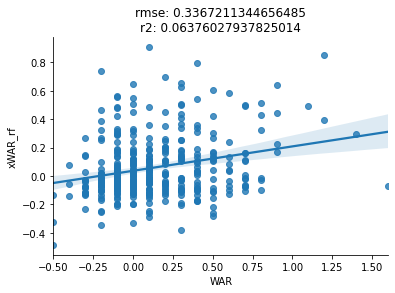

In [ ]:
target = 'WAR'
r2 = pearsonr(bats[target], bats[f"x{target}_rf"])[0]**2
rmse = mean_squared_error(bats[target], bats[f"x{target}_rf"])**0.5
sns.regplot(data=bats,x=target,y=f'x{target}_rf')
plt.title(f"""rmse: {rmse}\nr2: {r2}""")
sns.despine()
plt.show()

In [ ]:
bats.sort_values(f"x{target}_rf",ascending=False).loc[:, ['game_year', 'full_name', target, f"x{target}_rf", f"{target}_diff"]].head(20)

,game_year,full_name,WAR,xWAR_rf,WAR_diff
62,2021,"rizzo, anthony",0.1,0.907,-0.807
362,2021,"guerrero, vladimir",1.2,0.850,0.350
38,2021,"escobar, eduardo",0.4,0.795,-0.395
72,2021,"ozuna, marcell",-0.2,0.741,-0.941
355,2021,"garlick, kyle",0.2,0.697,-0.497
345,2021,"tucker, kyle",0.3,0.657,-0.357
11,2021,"blackmon, charlie",0.0,0.648,-0.648
334,2021,"mullins, cedric",0.9,0.641,0.259
150,2021,"judge, aaron",0.3,0.628,-0.328
126,2021,"naquin, tyler",0.5,0.607,-0.107


In [ ]:
bats.sort_values(f"x{target}_rf",ascending=False).loc[:, ['game_year', 'full_name', target, f"x{target}_rf", f"{target}_diff"]].tail(20)

,game_year,full_name,WAR,xWAR_rf,WAR_diff
285,2021,"hampson, garrett",0.0,-0.195,0.195
206,2021,"perez, michael",-0.1,-0.197,0.097
196,2021,"anderson, brian",0.0,-0.199,0.199
186,2021,"quinn, roman",-0.1,-0.201,0.101
223,2021,"gallo, joey",0.3,-0.208,0.508
191,2021,"severino, pedro",-0.1,-0.210,0.110
251,2021,"wendle, joey",0.5,-0.218,0.718
368,2021,"gurriel, lourdes",-0.3,-0.232,-0.068
162,2021,"polanco, jorge",-0.2,-0.244,0.044
140,2021,"iglesias, josé",0.1,-0.246,0.346


In [ ]:
bats.sort_values(f"{target}_diff",ascending=False).loc[:, ['game_year', 'full_name', target, f"x{target}_rf", f"{target}_diff"]].head(20)

,game_year,full_name,WAR,xWAR_rf,WAR_diff
343,2021,"acuna, ronald",1.6,-0.069,1.669
245,2021,"buxton, byron",1.4,0.298,1.102
51,2021,"marte, starling",0.8,-0.096,0.896
31,2021,"lowrie, jed",0.8,-0.027,0.827
143,2021,"canha, mark",0.8,-0.013,0.813
100,2021,"trout, mike",1.2,0.392,0.808
290,2021,"mcmahon, ryan",0.7,-0.105,0.805
130,2021,"seager, kyle",0.5,-0.284,0.784
109,2021,"narvaez, omar",0.7,-0.077,0.777
139,2021,"contreras, willson",0.7,-0.073,0.773


In [ ]:
bats.sort_values(f"{target}_diff",ascending=False).loc[:, ['game_year', 'full_name', target, f"x{target}_rf", f"{target}_diff"]].tail(20)

,game_year,full_name,WAR,xWAR_rf,WAR_diff
280,2021,"dozier, hunter",-0.3,0.151,-0.451
17,2021,"upton, justin",0.0,0.452,-0.452
226,2021,"williams, nick",-0.2,0.254,-0.454
195,2021,"ahmed, nick",-0.2,0.268,-0.468
373,2021,"rojas, josh",-0.4,0.078,-0.478
355,2021,"garlick, kyle",0.2,0.697,-0.497
181,2021,"story, trevor",0.0,0.510,-0.510
247,2021,"rios, edwin",-0.1,0.420,-0.520
313,2021,"chang, yu",-0.2,0.323,-0.523
310,2021,"mcbroom, ryan",0.0,0.547,-0.547


In [ ]:
bats_hr = bats.loc[:, ['batter','full_name', 'n_bip', 'is_home_run', 'is_home_run_rf']].groupby(['batter','full_name'], as_index=False).sum().sort_values(['is_home_run_rf', 'n_bip'], ascending=[False, True])
bats_hr['hr_diff'] = bats_hr['is_home_run'].sub(bats_hr['is_home_run_rf'])

In [ ]:
bats_hr.head(20)

,batter,full_name,n_bip,is_home_run,is_home_run_rf,hr_diff
105,547180,"harper, bryce",10,2,2.49,-0.49
26,467092,"ramos, wilson",12,2,2.15,-0.15
271,640457,"meadows, austin",13,2,1.90,0.10
345,663656,"tucker, kyle",12,2,1.80,0.20
245,621439,"buxton, byron",10,2,1.68,0.32
11,453568,"blackmon, charlie",14,1,1.65,-0.65
363,665742,"soto, juan",6,1,1.63,-0.63
133,572287,"zunino, mike",4,1,1.54,-0.54
221,608070,"ramirez, jose",11,2,1.51,0.49
362,665489,"guerrero, vladimir",13,1,1.37,-0.37


In [ ]:
bats_hr.tail(20)

,batter,full_name,n_bip,is_home_run,is_home_run_rf,hr_diff
92,543939,"wong, kolten",3,0,0.0,0.0
147,592325,"gamel, ben",3,0,0.0,0.0
203,605244,"garcia, aramis",3,0,0.0,0.0
231,608700,"plawecki, kevin",3,0,0.0,0.0
248,621466,"stewart, dj",3,0,0.0,0.0
329,656541,"hilliard, sam",3,0,0.0,0.0
353,664059,"haggerty, sam",3,0,0.0,0.0
124,571970,"muncy, max",4,0,0.0,0.0
136,573131,"ruf, darin",4,0,0.0,0.0
210,606132,"tapia, raimel",4,0,0.0,0.0


In [ ]:
bats_hr.sort_values('hr_diff', ascending=False).head(20)

,batter,full_name,n_bip,is_home_run,is_home_run_rf,hr_diff
290,641857,"mcmahon, ryan",10,2,0.93,1.07
66,520471,"galvis, freddy",3,1,0.09,0.91
228,608577,"mazara, nomar",9,1,0.09,0.91
192,600524,"nunez, renato",5,1,0.27,0.73
173,595879,"baez, javier",8,1,0.32,0.68
152,592567,"moran, colin",8,1,0.33,0.67
259,623520,"bote, david",10,1,0.42,0.58
42,502110,"martinez, j. d.",4,1,0.44,0.56
310,643436,"mcbroom, ryan",3,1,0.49,0.51
221,608070,"ramirez, jose",11,2,1.51,0.49


In [ ]:
bats_hr.sort_values('hr_diff', ascending=False).tail(20)

,batter,full_name,n_bip,is_home_run,is_home_run_rf,hr_diff
181,596115,"story, trevor",7,0,0.59,-0.59
334,656775,"mullins, cedric",14,0,0.60,-0.60
74,542583,"aguilar, jesus",9,0,0.62,-0.62
363,665742,"soto, juan",6,1,1.63,-0.63
328,656514,"haseley, adam",5,0,0.65,-0.65
11,453568,"blackmon, charlie",14,1,1.65,-0.65
128,572039,"piscotty, stephen",3,0,0.66,-0.66
199,605141,"betts, mookie",5,0,0.69,-0.69
323,650402,"torres, gleyber",13,0,0.72,-0.72
355,664247,"garlick, kyle",2,0,0.75,-0.75


In [ ]:
parks = bip.loc[:, ['home_team', 'park']].drop_duplicates()
park_factors = df_pred.loc[:, ['park', 'is_hr', 'is_hr_rf', 'hroe_rf', 'is_hr_pf']].groupby('park', as_index=False).sum()
park_factors = parks.merge(park_factors)

In [ ]:
def plot_park_factors(x, y, data):
  order = data.sort_values(x)[y].unique()
  sns.barplot(data=data, y=y, x=x, order = order)
  plt.axvline(0, c='k', ls=':')
  plt.gcf().set_size_inches(plt.gcf().get_size_inches()[0], 6)
  plt.xlabel('')
  sns.despine()
  plt.show()

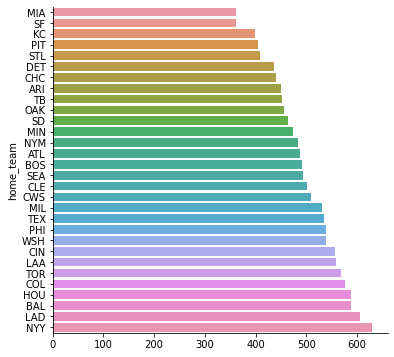

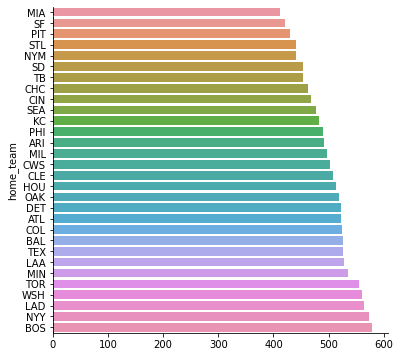

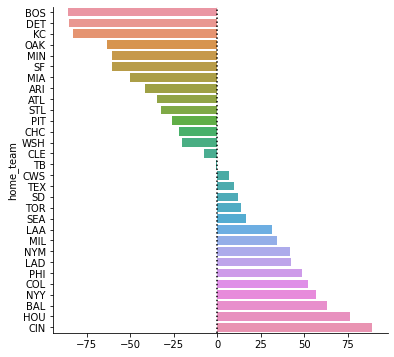

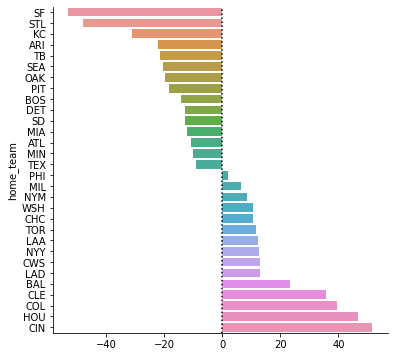

In [ ]:
y='home_team'
for x in ['is_hr', 'is_hr_rf', 'hroe_rf', 'is_hr_pf']:
  plot_park_factors(x, y, data=park_factors)

In [ ]:
_batter_hr = df_pred.loc[:, ['batter', 'hroe_rf']].groupby('batter', as_index=False).count().rename(columns={'hroe_rf':'n_bip'})
batter_hr = df_pred.loc[:, ['batter', 'is_hr', 'hroe_rf']].groupby('batter', as_index=False).sum().merge(_batter_hr)
batter_ids = pybaseball.playerid_reverse_lookup(batter_hr['batter'].unique())
batter_ids['full_name'] = batter_ids['name_last'].add(', ').add(batter_ids['name_first'])
id_join = batter_ids.loc[:, ['key_mlbam', 'full_name']].rename(columns={'key_mlbam':'batter'})
batter_hr = id_join.merge(batter_hr)

count    1207.000000
mean      245.761392
std       321.017869
min         1.000000
25%         7.500000
50%        71.000000
75%       409.000000
max      1297.000000
Name: n_bip, dtype: float64

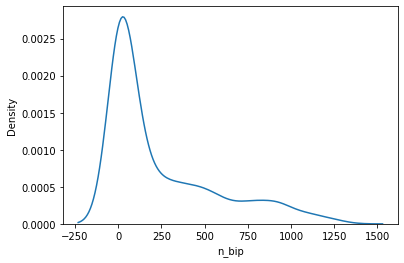

In [ ]:
sns.kdeplot(batter_hr['n_bip'])
batter_hr['n_bip'].describe()

In [ ]:
batter_hr.loc[batter_hr['n_bip']>=batter_hr['n_bip'].quantile(.67)].sort_values('hroe_rf').head(20)

,batter,full_name,is_hr,hroe_rf,n_bip
175,592206,"castellanos, nick",63,-24.37,1097
355,518692,"freeman, freddie",77,-19.40,1201
95,643217,"benintendi, andrew",29,-16.41,946
92,474832,"belt, brandon",40,-15.24,799
100,605141,"betts, mookie",79,-14.86,1216
401,502671,"goldschmidt, paul",77,-14.74,1035
1,660670,"acuna, ronald",84,-14.28,905
493,606192,"hernandez, teoscar",64,-14.03,710
1145,458015,"votto, joey",38,-13.94,948
201,425783,"choo, shin-soo",50,-13.25,878
